In [1]:
# Import for preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection  import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import shap



from sklearn import set_config
set_config(transform_output='pandas')

c:\Users\nick_\anaconda3\envs\foozball\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to check metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

def eval_classification(model, X_train, y_train, X_test, y_test, model_name = 'model', results_frame = None, pos_label=1, average='binary', roc_auc_avg = 'macro'):

  model.fit(X_train, y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)

  if y_train.nunique() > 2 and average == 'binary':
    average = 'macro'

  print('Train Evaluation')
  print(classification_report(y_train, train_pred))
  ConfusionMatrixDisplay.from_predictions(y_train, train_pred, normalize='true', cmap='Blues')
  plt.show()

  print('Test Evaluation')
  print(classification_report(y_test, test_pred))
  ConfusionMatrixDisplay.from_predictions(y_test, test_pred, normalize='true', cmap='Greens')
  plt.show()

  results = pd.DataFrame(index=[model_name])
  results['train_acc'] = accuracy_score(y_train, train_pred)
  results['test_acc'] = accuracy_score(y_test, test_pred)
  results['train_prec'] = precision_score(y_train, train_pred, pos_label=pos_label, average=average)
  results['test_prec'] = precision_score(y_test, test_pred, pos_label=pos_label, average=average)
  results['train_recall'] = recall_score(y_train, train_pred, pos_label=pos_label, average=average)
  results['test_recall'] = recall_score(y_test, test_pred, pos_label=pos_label, average=average)
  results['train_f1'] = f1_score(y_train, train_pred, pos_label=pos_label, average=average)
  results['test_f1'] = f1_score(y_test, test_pred, pos_label=pos_label, average=average)
  results['train_auc'] = roc_auc_score(y_train, model.predict_proba(X_train)[:,1], average=roc_auc_avg, multi_class='ovr')
  results['test_auc'] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1], average=roc_auc_avg, multi_class='ovr')

  if results_frame is not None:
    results = pd.concat([results_frame, results])

  return results

In [3]:
# import

df = pd.read_csv('merged_clean.csv')
df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles
0,2009.0,PHI,ACT,70.0,200.0,00-0000108,12.0,WC,1997.0,35.0,David Akers,K,00-0000108_2009_David_Akers_K,18.0,18.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010.0,PHI,ACT,70.0,200.0,00-0000108,13.0,WC,1997.0,36.0,David Akers,K,00-0000108_2010_David_Akers_K,18.0,18.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hamstring,Active,Hamstring,Full Participation in Practice,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011.0,SF,ACT,70.0,200.0,00-0000108,14.0,CON,1997.0,37.0,David Akers,K,00-0000108_2011_David_Akers_K,20.0,20.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047313,1.0,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012.0,SF,ACT,70.0,200.0,00-0000108,15.0,SB,1997.0,38.0,David Akers,K,00-0000108_2012_David_Akers_K,21.0,21.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hip,Probable,Hip,Full Participation in Practice,0.0,0.0,5.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013.0,DET,ACT,70.0,200.0,00-0000108,16.0,REG,1997.0,39.0,David Akers,K,00-0000108_2013_David_Akers_K,17.0,17.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13494,2024.0,SEA,CUT,67.0,195.0,00-0039940,0.0,REG,2024.0,24.0,Kairee Robinson,RB,00-0039940_2024_Kairee_Robinson_RB,0.0,18.0,18.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13495,2024.0,KC,CUT,77.0,240.0,00-0039941,0.0,REG,2024.0,25.0,Geor'Quarius Spivey,TE,00-0039941_2024_Geor'Quarius_Spivey_TE,0.0,22.0,22.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [4]:
df = df.sort_values(['player_id_x', 'season_x'], ascending=False)
df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles
13498,2024.0,SEA,CUT,78.0,240.0,00-0039952,0.0,REG,2024.0,25.0,Devon Garrison,TE,00-0039952_2024_Devon_Garrison_TE,0.0,18.0,18.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13497,2024.0,GB,DEV,72.0,205.0,00-0039945,0.0,WC,2024.0,26.0,Alex Hale,K,00-0039945_2024_Alex_Hale_K,0.0,19.0,19.0,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13496,2024.0,NO,CUT,76.0,260.0,00-0039942,0.0,REG,2024.0,23.0,Mason Fairchild,TE,00-0039942_2024_Mason_Fairchild_TE,0.0,18.0,18.0,2001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13495,2024.0,KC,CUT,77.0,240.0,00-0039941,0.0,REG,2024.0,25.0,Geor'Quarius Spivey,TE,00-0039941_2024_Geor'Quarius_Spivey_TE,0.0,22.0,22.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13494,2024.0,SEA,CUT,67.0,195.0,00-0039940,0.0,REG,2024.0,24.0,Kairee Robinson,RB,00-0039940_2024_Kairee_Robinson_RB,0.0,18.0,18.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2013.0,DET,ACT,70.0,200.0,00-0000108,16.0,REG,1997.0,39.0,David Akers,K,00-0000108_2013_David_Akers_K,17.0,17.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012.0,SF,ACT,70.0,200.0,00-0000108,15.0,SB,1997.0,38.0,David Akers,K,00-0000108_2012_David_Akers_K,21.0,21.0,0.0,1974.0,0.0,

In [5]:
df['years_exp']

# make sure you are cycling over players

#filter and shift for only each play

# drop nans

df['next_season_missed'] = df.groupby('player_id_x')['missed_games'].shift(1)

In [6]:
df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed
13498,2024.0,SEA,CUT,78.0,240.0,00-0039952,0.0,REG,2024.0,25.0,Devon Garrison,TE,00-0039952_2024_Devon_Garrison_TE,0.0,18.0,18.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
13497,2024.0,GB,DEV,72.0,205.0,00-0039945,0.0,WC,2024.0,26.0,Alex Hale,K,00-0039945_2024_Alex_Hale_K,0.0,19.0,19.0,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
13496,2024.0,NO,CUT,76.0,260.0,00-0039942,0.0,REG,2024.0,23.0,Mason Fairchild,TE,00-0039942_2024_Mason_Fairchild_TE,0.0,18.0,18.0,2001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
13495,2024.0,KC,CUT,77.0,240.0,00-0039941,0.0,REG,2024.0,25.0,Geor'Quarius Spivey,TE,00-0039941_2024_Geor'Quarius_Spivey_TE,0.0,22.0,22.0,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
13494,2024.0,SEA,CUT,67.0,195.0,00-0039940,0.0,REG,2024.0,24.0,Kairee Robinson,RB,00-0039940_2024_Kairee_Robinson_RB,0.0,18.0,18.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2013.0,DET,ACT,70.0,200.0,00-0000108,16.0,REG,1997.0,39.0,David Akers,K,00-0000108_2013_David_Akers_K,17.0,17.0,0.0,1974.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2012.0,SF,ACT,70.0,200.0,00-0000108,15.0,SB,1997.0,38.0,David Akers,K,00-00001

In [7]:
df['missed4'] = np.where(df['next_season_missed'] >= 4, 1, 0)

In [8]:
df['next_season_missed'].isna().sum()

3438

In [9]:
df['player_id_x'].nunique()

3438

In [10]:
# df = df.dropna(subset='next_season_missed')

In [11]:
df[(df['years_exp'] > 0) & (df['season_x'] == 2024)]

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed,missed4
13272,2024.0,DET,ACT,70.0,202.0,00-0039172,1.0,DIV,2023.0,25.0,Jake Bates,K,00-0039172_2024_Jake_Bates_K,18.0,20.0,2.0,1999.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
13271,2024.0,SEA,ACT,73.0,220.0,00-0039165,1.0,REG,2023.0,23.0,Zach Charbonnet,RB,00-0039165_2024_Zach_Charbonnet_RB,17.0,18.0,1.0,2001.0,0.087690,-0.013126,0.157678,0.070336,0.047619,0.033175,0.034483,0.519393,0.125345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0,569.0,8.0,0.0,0.0,32.0,0.0,42.0,52.0,308.0,1.0,0.0,0.0,-54.0,345.0,7.0,0.0,0.0,Elbow,Active,Elbow,Full Participation in Practice,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
13269,2024.0,IND,INA,76.0,232.0,00-0039164,1.0,REG,2023.0,22.0,Anthony Richardson,QB,00-0039164_2024_Anthony_Richardson_QB,13.0,18.0,5.0,2002.0,0.003448,-0.002288,0.008235,-0.000505,0.000000,0.000000,0.000000,-0.003448,0.218343,126.0,264.0,1814.0,8.0,12.0,14.0,115.0,3.0,2.0,3224.0,73.0,0.0,86.0,499.0,6.0,6.0,1.0,33.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.0,-8.0,7.0,0.0,0.0,0.0,Back,Out,Back,Did Not Participate In Practice,0.0,0.0,0.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,NaN,0
13267,2024.0,HOU,ACT,75.0,218.0,00-0039163,1.0,DIV,2023.0,23.0,C.J. Stroud,QB,00-0039163_2024_C.J._Stroud_QB,19.0,20.0,1.0,2001.0,0.001585,0.001908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.165953,377.0,593.0,4254.0,21.0,13.0,63.0,487.0,5.0,2.0,5011.0,211.0,0.0,64.0,317.0,0.0,3.0,2.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,Hand,Active,Hand,Full Participation in Practice,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
13265,2024.0,TEN,ACT,76.0,232.0,00-0039152,1.0,REG,2023.0,25.0,Will Levis,QB,00-0039152_2024_Will_Levis_QB,14.0,18.0,4.0,1999.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140709,190.0,301.0,2091.0,13.0,12.0,41.0,233.0,5.0,3.0,2621.0,86.0,1.0,45.0,183.0,0.0,5.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shoulder,Questionable,Shoulder,Limited Participation in Practice,0.0,0.0,0.0,4.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,2024.0,ATL,RET,76.0,217.0,00-0026143,16.0,REG,2008.0,39.0,Matt Ryan,QB,00-0026143_2024_Matt_Ryan_QB,0.0,18.0,18.0,1985.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [12]:
train_df = df[df['season_x'] < 2023]
test_df = df[df['season_x'] == 2023]

In [13]:
test_df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed,missed4
13270,2023.0,SEA,ACT,73.0,220.0,00-0039165,0.0,REG,2023.0,22.0,Zach Charbonnet,RB,00-0039165_2023_Zach_Charbonnet_RB,16.0,18.0,2.0,2001.0,0.072595,-0.010534,0.125506,0.052938,0.000,0.039326,0.035176,0.379310,0.080979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,462.0,1.0,0.0,0.0,32.0,0.0,33.0,40.0,209.0,0.0,0.0,0.0,-41.0,248.0,7.0,0.0,0.0,Knee,Questionable,Knee,Full Participation in Practice,0.0,0.0,0.0,2.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
13268,2023.0,IND,RES,76.0,232.0,00-0039164,0.0,REG,2023.0,21.0,Anthony Richardson,QB,00-0039164_2023_Anthony_Richardson_QB,4.0,18.0,14.0,2002.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.213689,50.0,84.0,577.0,3.0,1.0,7.0,29.0,1.0,0.0,676.0,31.0,2.0,25.0,136.0,4.0,2.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Concussion,Active,Concussion,Full Participation in Practice,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1
13266,2023.0,HOU,ACT,75.0,218.0,00-0039163,0.0,DIV,2023.0,22.0,C.J. Stroud,QB,00-0039163_2023_C.J._Stroud_QB,17.0,20.0,3.0,2001.0,0.001779,-0.000201,0.000491,0.000000,0.000,0.000000,0.000000,0.000000,0.206308,354.0,553.0,4557.0,26.0,5.0,38.0,331.0,6.0,3.0,4908.0,206.0,0.0,43.0,167.0,3.0,2.0,1.0,17.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,Concussion,Active,Concussion,Full Participation in Practice,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0
13264,2023.0,TEN,INA,76.0,232.0,00-0039152,0.0,REG,2023.0,24.0,Will Levis,QB,00-0039152_2023_Will_Levis_QB,9.0,18.0,9.0,1999.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.159821,149.0,255.0,1808.0,8.0,4.0,28.0,185.0,5.0,2.0,2688.0,81.0,1.0,25.0,57.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Foot,Questionable,Foot,Limited Participation in Practice,0.0,0.0,0.0,2.0,8.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,1
13262,2023.0,CAR,ACT,70.0,194.0,00-0039150,0.0,REG,2023.0,22.0,Bryce Young,QB,00-0039150_2023_Bryce_Young_QB,16.0,18.0,2.0,2001.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.154486,315.0,527.0,2877.0,11.0,10.0,62.0,477.0,9.0,6.0,4009.0,133.0,1.0,39.0,253.0,0.0,2.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Back,Active,Back,Full Participation in Practice,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,2023.0,NYG,ACT,73.0,207.0,00-0025580,16.0,REG,2007.0,39.0,Mason Crosby,K,00-0025580_2023_Mason_Crosby_K,3.0,18.0,15.0,1984.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00

In [14]:
test_df['next_season_missed'].isna().sum()

173

In [15]:
test_df = test_df.dropna(subset='next_season_missed')

In [16]:
test_df['season_x'].value_counts()

2023.0    793
Name: season_x, dtype: int64

In [17]:
test_df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed,missed4
13270,2023.0,SEA,ACT,73.0,220.0,00-0039165,0.0,REG,2023.0,22.0,Zach Charbonnet,RB,00-0039165_2023_Zach_Charbonnet_RB,16.0,18.0,2.0,2001.0,0.072595,-0.010534,0.125506,0.052938,0.000,0.039326,0.035176,0.379310,0.080979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,462.0,1.0,0.0,0.0,32.0,0.0,33.0,40.0,209.0,0.0,0.0,0.0,-41.0,248.0,7.0,0.0,0.0,Knee,Questionable,Knee,Full Participation in Practice,0.0,0.0,0.0,2.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
13268,2023.0,IND,RES,76.0,232.0,00-0039164,0.0,REG,2023.0,21.0,Anthony Richardson,QB,00-0039164_2023_Anthony_Richardson_QB,4.0,18.0,14.0,2002.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.213689,50.0,84.0,577.0,3.0,1.0,7.0,29.0,1.0,0.0,676.0,31.0,2.0,25.0,136.0,4.0,2.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Concussion,Active,Concussion,Full Participation in Practice,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1
13266,2023.0,HOU,ACT,75.0,218.0,00-0039163,0.0,DIV,2023.0,22.0,C.J. Stroud,QB,00-0039163_2023_C.J._Stroud_QB,17.0,20.0,3.0,2001.0,0.001779,-0.000201,0.000491,0.000000,0.000,0.000000,0.000000,0.000000,0.206308,354.0,553.0,4557.0,26.0,5.0,38.0,331.0,6.0,3.0,4908.0,206.0,0.0,43.0,167.0,3.0,2.0,1.0,17.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,Concussion,Active,Concussion,Full Participation in Practice,1.0,0.0,0.0,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0
13264,2023.0,TEN,INA,76.0,232.0,00-0039152,0.0,REG,2023.0,24.0,Will Levis,QB,00-0039152_2023_Will_Levis_QB,9.0,18.0,9.0,1999.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.159821,149.0,255.0,1808.0,8.0,4.0,28.0,185.0,5.0,2.0,2688.0,81.0,1.0,25.0,57.0,1.0,2.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Foot,Questionable,Foot,Limited Participation in Practice,0.0,0.0,0.0,2.0,8.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,1
13262,2023.0,CAR,ACT,70.0,194.0,00-0039150,0.0,REG,2023.0,22.0,Bryce Young,QB,00-0039150_2023_Bryce_Young_QB,16.0,18.0,2.0,2001.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.154486,315.0,527.0,2877.0,11.0,10.0,62.0,477.0,9.0,6.0,4009.0,133.0,1.0,39.0,253.0,0.0,2.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Back,Active,Back,Full Participation in Practice,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028,2023.0,CLE,ACT,78.0,245.0,00-0026158,15.0,WC,2008.0,38.0,Joe Flacco,QB,00-0026158_2023_Joe_Flacco_QB,7.0,19.0,12.0,1985.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.00000

In [18]:
train_df['next_season_missed'].isna().sum()

2229

In [19]:
train_df = train_df.dropna(subset='next_season_missed')

In [20]:
train_df

,season_x,team_x,status,height,weight,player_id_x,years_exp,game_type_x,entry_year,age,cleaned_name_x,std_pos_x,unique_id,active_games,max_week,missed_games,birth_year,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,report_primary_injury,report_status,practice_primary_injury,practice_status,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,next_season_missed,missed4
12910,2022.0,ATL,ACT,72.0,193.0,00-0038149,0.0,REG,2022.0,23.0,Josh Ali,WR,00-0038149_2022_Josh_Ali_WR,2.0,18.0,16.0,1999.0,0.033333,0.127119,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1
12907,2022.0,CLE,DEV,74.0,219.0,00-0038147,0.0,REG,2022.0,23.0,Daylen Baldwin,WR,00-0038147_2022_Daylen_Baldwin_WR,1.0,18.0,17.0,1999.0,0.071429,0.193798,0.00000,0.155280,0.0,0.200000,0.181818,0.892857,0.069402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,25.0,0.0,0.0,0.0,25.0,0.0,2.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1
12904,2022.0,TEN,DEV,78.0,260.0,00-0038145,0.0,REG,2022.0,25.0,Thomas Odukoya,TE,00-0038145_2022_Thomas_Odukoya_TE,0.0,18.0,18.0,1997.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1
12900,2022.0,SEA,ACT,69.0,210.0,00-0038134,0.0,WC,2022.0,22.0,Kenneth Walker,RB,00-0038134_2022_Kenneth_Walker_RB,16.0,19.0,3.0,2000.0,0.066176,-0.018262,0.13046,0.041217,0.0,0.030303,0.026667,0.308824,0.147303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0,1113.0,10.0,0.0,0.0,55.0,0.0,28.0,36.0,168.0,0.0,0.0,0.0,-75.0,224.0,6.0,0.0,0.0,Ankle,Active,Ankle,Limited Participation in Practice,0.0,0.0,0.0,5.0,6.0,3.0,3.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
12897,2022.0,CAR,RES,74.0,205.0,00-0038132,0.0,REG,2022.0,23.0,Matt Corral,QB,00-0038132_2022_Matt_Corral_QB,0.0,18.0,18.0,1999.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Inj,Active,No Inj,Full Participation In Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2009.0,PIT,ACT,74.0,216.0,00-0000865,11.0,REG,1998.0,35.0,Charlie Batch,QB,00-0000865_2009_Charlie_Batch_QB,17.0,17.0,0.0,1974.0,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.005375,1.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [21]:
col_list = train_df.columns.to_list()

In [22]:
col_list

['season_x',
 'team_x',
 'status',
 'height',
 'weight',
 'player_id_x',
 'years_exp',
 'game_type_x',
 'entry_year',
 'age',
 'cleaned_name_x',
 'std_pos_x',
 'unique_id',
 'active_games',
 'max_week',
 'missed_games',
 'birth_year',
 'tgt_sh',
 'ay_sh',
 'yac_sh',
 'ry_sh',
 'rtd_sh',
 'rfd_sh',
 'rtdfd_sh',
 'yptmpa',
 'ppr_sh',
 'completions_summed',
 'attempts_summed',
 'passing_yards_summed',
 'passing_tds_summed',
 'interceptions_summed',
 'sacks_summed',
 'sack_yards_summed',
 'sack_fumbles_summed',
 'sack_fumbles_lost_summed',
 'passing_air_yards_summed',
 'passing_first_downs_summed',
 'passing_2pt_conversions_summed',
 'carries_summed',
 'rushing_yards_summed',
 'rushing_tds_summed',
 'rushing_fumbles_summed',
 'rushing_fumbles_lost_summed',
 'rushing_first_downs_summed',
 'rushing_2pt_conversions_summed',
 'receptions_summed',
 'targets_summed',
 'receiving_yards_summed',
 'receiving_tds_summed',
 'receiving_fumbles_summed',
 'receiving_fumbles_lost_summed',
 'receiving_air

In [23]:
X_train = train_df.drop(columns=['status', 'player_id_x', 'cleaned_name_x', 'unique_id', 'active_games', 'report_primary_injury',
                                 'report_status', 'practice_primary_injury', 'practice_status', 'next_season_missed', 'missed4', 'birth_year'])

y_train = train_df['missed4'].copy()

X_test = test_df.drop(columns=['status', 'player_id_x', 'cleaned_name_x', 'unique_id', 'active_games', 'report_primary_injury',
                                 'report_status', 'practice_primary_injury', 'practice_status', 'next_season_missed', 'missed4', 'birth_year'])

y_test = test_df['missed4'].copy()

In [24]:
X_train.columns

Index(['season_x', 'team_x', 'height', 'weight', 'years_exp', 'game_type_x',
       'entry_year', 'age', 'std_pos_x', 'max_week', 'missed_games', 'tgt_sh',
       'ay_sh', 'yac_sh', 'ry_sh', 'rtd_sh', 'rfd_sh', 'rtdfd_sh', 'yptmpa',
       'ppr_sh', 'completions_summed', 'attempts_summed',
       'passing_yards_summed', 'passing_tds_summed', 'interceptions_summed',
       'sacks_summed', 'sack_yards_summed', 'sack_fumbles_summed',
       'sack_fumbles_lost_summed', 'passing_air_yards_summed',
       'passing_first_downs_summed', 'passing_2pt_conversions_summed',
       'carries_summed', 'rushing_yards_summed', 'rushing_tds_summed',
       'rushing_fumbles_summed', 'rushing_fumbles_lost_summed',
       'rushing_first_downs_summed', 'rushing_2pt_conversions_summed',
       'receptions_summed', 'targets_summed', 'receiving_yards_summed',
       'receiving_tds_summed', 'receiving_fumbles_summed',
       'receiving_fumbles_lost_summed', 'receiving_air_yards_summed',
       'receiving_yards_

In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9268 entries, 12910 to 0
Data columns (total 66 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   season_x                            9268 non-null   float64
 1   team_x                              9268 non-null   object 
 2   height                              9268 non-null   float64
 3   weight                              9268 non-null   float64
 4   years_exp                           9268 non-null   float64
 5   game_type_x                         9268 non-null   object 
 6   entry_year                          9268 non-null   float64
 7   age                                 9268 non-null   float64
 8   std_pos_x                           9268 non-null   object 
 9   max_week                            9268 non-null   float64
 10  missed_games                        9268 non-null   float64
 11  tgt_sh                              9268 n

In [26]:
# Make transformers for preprocess

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = MinMaxScaler()

In [27]:
ohe_cols = list(X_train.select_dtypes('object').columns)
nums_cols = list(X_train.select_dtypes('float64').columns)

In [28]:
# Make the encoder for pipeline

proc_encode = ColumnTransformer([
  ('ohe', ohe, ohe_cols)
], remainder = 'passthrough', verbose_feature_names_out=False)

In [29]:
# Scaler transformer for pipeline

proc_scale = ColumnTransformer([
  ('scaler', scaler, nums_cols)
], remainder='passthrough', verbose_feature_names_out=False)

In [30]:
main_pipe = Pipeline([
  ('proc_encode', proc_encode),
  ('proc_scale', proc_scale)
])

In [31]:
main_pipe.fit(X_train)

c:\Users\nick_\anaconda3\envs\foozball\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('proc_encode',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['team_x', 'game_type_x',
                                                   'std_pos_x'])],
                                   verbose_feature_names_out=False)),
                ('proc_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['season_x', 'height',
                                                   'weight'...
                                                   'rtdfd_sh', 'yptmpa',
                                                   'ppr_sh',
                                                   'completions_summed',
                                                   'attempts_summed',
                                                   'passing_yards_summed',
                                                   'passing_tds_summed',
                                                   'interceptions_summed',
                                                   'sacks_summed',
                                                   'sack_yards_summed',
                                                   'sack_fumbles_summed',
                                                   'sack_fumbles_lost_summed',
                                                   'passing_air_yards_summed',
                                                   'passing_first_downs_summed',
                                                   'passing_2pt_conversions_summed',
                                                   'carries_summed', ...])],
                                   verbose_feature_names_out=False))])

In [32]:
X_train_proc = main_pipe.transform(X_train)
X_test_proc = main_pipe.transform(X_test)

In [33]:
X_train_proc.head()

,season_x,height,weight,years_exp,entry_year,age,max_week,missed_games,tgt_sh,ay_sh,yac_sh,ry_sh,rtd_sh,rfd_sh,rtdfd_sh,yptmpa,ppr_sh,completions_summed,attempts_summed,passing_yards_summed,passing_tds_summed,interceptions_summed,sacks_summed,sack_yards_summed,sack_fumbles_summed,sack_fumbles_lost_summed,passing_air_yards_summed,passing_first_downs_summed,passing_2pt_conversions_summed,carries_summed,rushing_yards_summed,rushing_tds_summed,rushing_fumbles_summed,rushing_fumbles_lost_summed,rushing_first_downs_summed,rushing_2pt_conversions_summed,receptions_summed,targets_summed,receiving_yards_summed,receiving_tds_summed,receiving_fumbles_summed,receiving_fumbles_lost_summed,receiving_air_yards_summed,receiving_yards_after_catch_summed,receiving_first_downs_summed,receiving_2pt_conversions_summed,special_teams_tds_summed,doubt,out,prob,quest,fp,dnp,lp,Hamstring,Knee,Ankle,Groin,Neck,Concussion,Foot,Back,Achilles,team_x_ARI,team_x_ARZ,team_x_ATL,team_x_BAL,team_x_BLT,team_x_BUF,team_x_CAR,team_x_CHI,team_x_CIN,team_x_CLE,team_x_CLV,team_x_DAL,team_x_DEN,team_x_DET,team_x_GB,team_x_HOU,team_x_HST,team_x_IND,team_x_JAX,team_x_KC,team_x_LA,team_x_LAC,team_x_LV,team_x_MIA,team_x_MIN,team_x_NE,team_x_NO,team_x_NYG,team_x_NYJ,team_x_OAK,team_x_PHI,team_x_PIT,team_x_SD,team_x_SEA,team_x_SF,team_x_SL,team_x_TB,team_x_TEN,team_x_WAS,game_type_x_CON,game_type_x_DIV,game_type_x_REG,game_type_x_SB,game_type_x_WC,std_pos_x_K,std_pos_x_QB,std_pos_x_RB,std_pos_x_TE,std_pos_x_WR
12910,1.0,0.4375,0.267081,0.0,1.0,0.076923,0.2,0.727273,0.083333,0.350538,0.072107,0.057877,0.0,0.000000,0.000000,0.040199,0.478312,0.0,0.0,0.000928,0.0,0.0,0.0,0.0,0.0,0.0,0.001681,0.0,0.0,0.000000,0.014805,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.004292,0.006555,0.0,0.0,0.0,0.058069,0.007547,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12907,1.0,0.5625,0.428571,0.0,1.0,0.076923,0.2,0.772727,0.178571,0.457429,0.072107,0.377819,0.0,0.434667,0.389006,0.205302,0.583631,0.0,0.0,0.000928,0.0,0.0,0.0,0.0,0.0,0.0,0.001681,0.0,0.0,0.000000,0.014805,0.00000,0.0,0.0,0.000000,0.0,0.011236,0.008584,0.016796,0.0,0.0,0.0,0.051317,0.007547,0.018519,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12904,1.0,0.8125,0.683230,0.0,1.0,0.153846,0.2,0.818182,0.000000,0.146759,0.072107,0.057877,0.0,0.000000,0.000000,0.040199,0.478312,0.0,0.0,0.000928,0.0,0.0,0.0,0.0,0.0,0.0,0.001681,0.0,0.0,0.000000,0.014805,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.006555,0.0,0.0,0.0,0.042876,0.007547,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12900,1.0,0.2500,0.372671,0.0,1.0,0.038462,0.4,0.136364,0.165441,0.117485,0.316693,0.142801,0.0,0.065859,0.057054,0.097305,0.701848,0.0,0.0,0.000928,0.0,0.0,0.0,0.0,0.0,0.0,0.001681,0.0,0.0,0.557339,0.514132,0.47619,0.0,0.0,0.514019,0.0,0.157303,0.154506,0.075379,0.0,0.0,0.0,0.017556,0.218868,0.055556,0.0,0.0,0.0,0.0,0.0,0.333333,0.315789,0.176471,0.157895,0.0,0.066667,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
12897,1.0,0.5625,0.341615,0.0,1.0,0.076923,0.2,0.818182,0.000000,0.146759,0.072107,0.057877,0.0,0.000000,0.000000,0.040199,0.478

In [34]:
logreg_balc = LogisticRegression(max_iter=1000)

Train Evaluation
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      4679
           1       0.74      0.69      0.72      4589

    accuracy                           0.73      9268
   macro avg       0.73      0.73      0.73      9268
weighted avg       0.73      0.73      0.73      9268



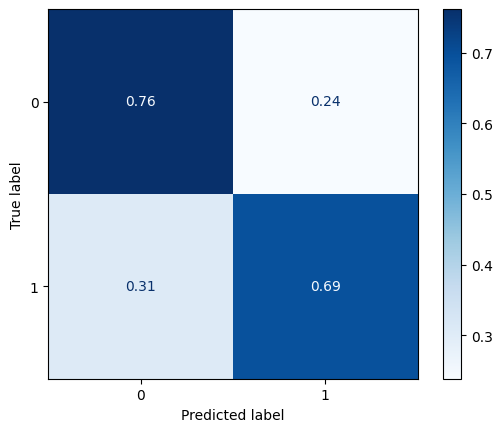

Test Evaluation
              precision    recall  f1-score   support

           0       0.64      0.33      0.44       269
           1       0.72      0.90      0.80       524

    accuracy                           0.71       793
   macro avg       0.68      0.62      0.62       793
weighted avg       0.69      0.71      0.68       793



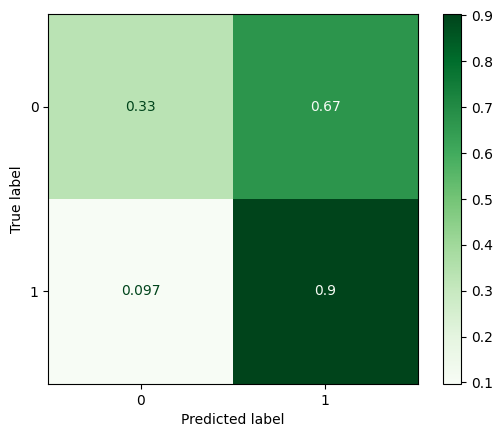

In [35]:
log_reg = eval_classification(logreg_balc, X_train_proc, y_train, X_test_proc, y_test, model_name='log_reg_notune')

In [36]:
log_reg

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.708701,0.740646,0.724349,0.694487,0.902672,0.716824,0.803738,0.796646,0.794191


In [37]:
# tune decision threshold to make more stringent

In [38]:
dt = DecisionTreeClassifier()

Train Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4679
           1       1.00      1.00      1.00      4589

    accuracy                           1.00      9268
   macro avg       1.00      1.00      1.00      9268
weighted avg       1.00      1.00      1.00      9268



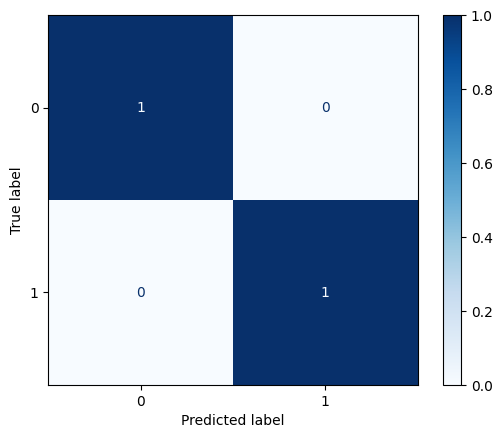

Test Evaluation
              precision    recall  f1-score   support

           0       0.48      0.52      0.50       269
           1       0.74      0.71      0.73       524

    accuracy                           0.65       793
   macro avg       0.61      0.62      0.62       793
weighted avg       0.66      0.65      0.65       793



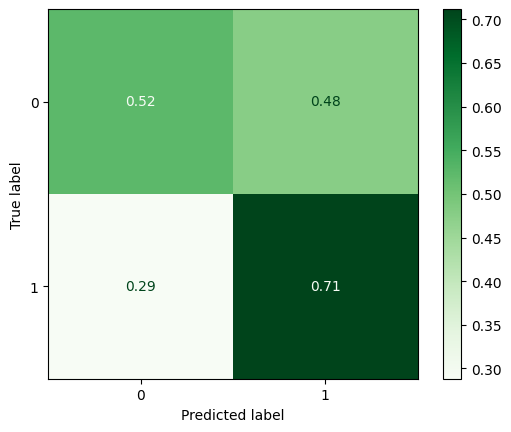

In [39]:
tree = eval_classification(dt, X_train_proc, y_train, X_test_proc, y_test, model_name= 'dt_no_tune', results_frame=log_reg)

In [40]:
dt

DecisionTreeClassifier()

In [41]:
rf = RandomForestClassifier()

Train Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4679
           1       1.00      1.00      1.00      4589

    accuracy                           1.00      9268
   macro avg       1.00      1.00      1.00      9268
weighted avg       1.00      1.00      1.00      9268



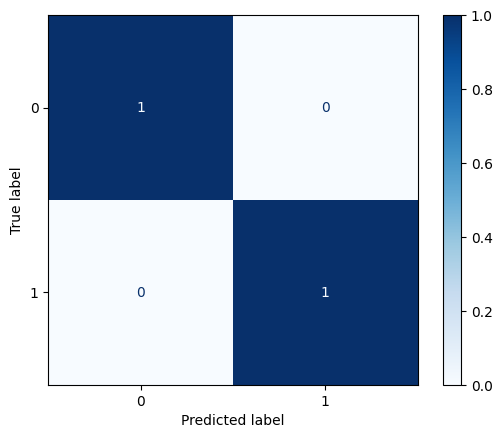

Test Evaluation
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       269
           1       0.80      0.82      0.81       524

    accuracy                           0.74       793
   macro avg       0.71      0.71      0.71       793
weighted avg       0.74      0.74      0.74       793



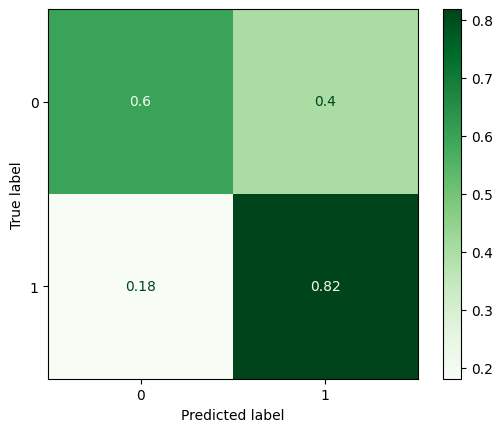

In [42]:
forest = eval_classification(rf, X_train_proc, y_train, X_test_proc, y_test, model_name="rf_no_tune", results_frame=tree)

In [43]:
forest

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.708701,0.740646,0.724349,0.694487,0.902672,0.716824,0.803738,0.796646,0.794191
dt_no_tune,1.000000,0.648172,1.000000,0.744511,1.000000,0.711832,1.000000,0.727805,1.000000,0.617998
rf_no_tune,1.000000,0.744010,1.000000,0.798883,1.000000,0.818702,1.000000,0.808671,1.000000,0.800796


In [44]:
# create estimators variable
estimators =  rf.estimators_

# check that it correctly shows for first tree
estimators[0]

DecisionTreeClassifier(max_features='sqrt', random_state=219206407)

In [45]:
# Check for the maximum depth across all the trees

depths = [est.get_depth() for est in estimators]
max(depths)

58

In [46]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [47]:
rf_pipe = make_pipeline(rf)
rf_pipe.get_params()

{'memory': None,
 'steps': [('randomforestclassifier', RandomForestClassifier())],
 'transform_input': None,
 'verbose': False,
 'randomforestclassifier': RandomForestClassifier(),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__monotonic_cst': None,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': None,
 'randomforest

In [48]:
params = {'randomforestclassifier__max_depth' : range(1, 56, 5)}

# Run grid search

rf_gs = GridSearchCV(rf_pipe, param_grid=params, n_jobs =-1, cv=3, verbose =1, scoring = 'roc_auc').fit(X_train_proc, y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


In [49]:
# check for best depth

print(f'RF Best depth - {rf_gs.best_params_}')

# make model with best depth

rf_best_depth = rf_gs.best_estimator_

RF Best depth - {'randomforestclassifier__max_depth': 1}


Train Evaluation
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      4679
           1       0.65      0.69      0.67      4589

    accuracy                           0.67      9268
   macro avg       0.67      0.67      0.67      9268
weighted avg       0.67      0.67      0.67      9268



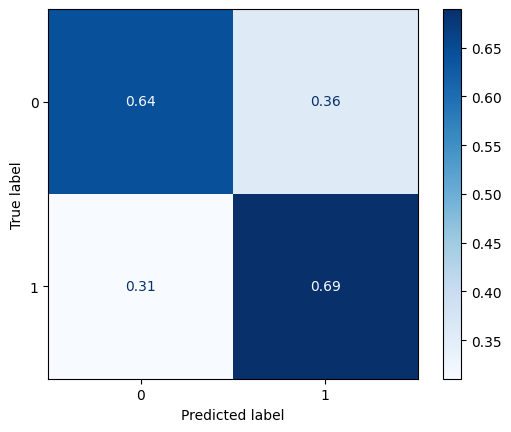

Test Evaluation
              precision    recall  f1-score   support

           0       0.55      0.54      0.54       269
           1       0.76      0.77      0.77       524

    accuracy                           0.69       793
   macro avg       0.65      0.65      0.65       793
weighted avg       0.69      0.69      0.69       793



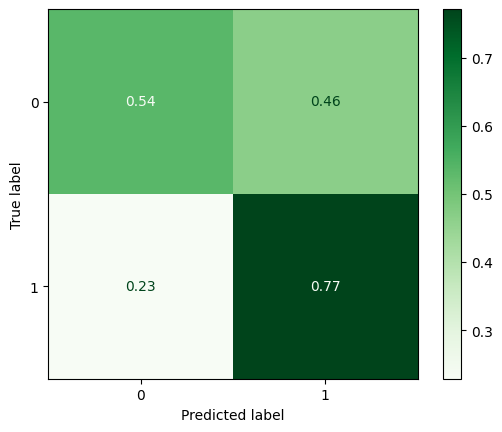

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.708701,0.740646,0.724349,0.694487,0.902672,0.716824,0.803738,0.796646,0.794191
dt_no_tune,1.000000,0.648172,1.000000,0.744511,1.000000,0.711832,1.000000,0.727805,1.000000,0.617998
rf_no_tune,1.000000,0.744010,1.000000,0.798883,1.000000,0.818702,1.000000,0.808671,1.000000,0.800796
RF 1 depth,0.665947,0.691047,0.654395,0.763705,0.689475,0.770992,0.671477,0.767331,0.745223,0.764810


In [50]:

rf_1 = eval_classification(rf_best_depth, X_train_proc, y_train, X_test_proc, y_test, model_name='RF 1 depth', results_frame=forest)
rf_1

In [51]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [52]:
import xgboost as xgb


In [53]:


boosted = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    max_depth=3,            # Maximum tree depth
    random_state=42,
    objective='binary:logistic',

                    # For reproducibility
)

Train Evaluation
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      4679
           1       0.79      0.67      0.73      4589

    accuracy                           0.75      9268
   macro avg       0.75      0.75      0.75      9268
weighted avg       0.75      0.75      0.75      9268



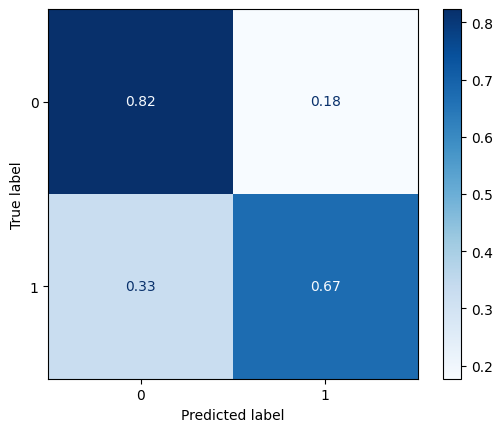

Test Evaluation
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       269
           1       0.79      0.83      0.81       524

    accuracy                           0.74       793
   macro avg       0.71      0.70      0.70       793
weighted avg       0.73      0.74      0.74       793



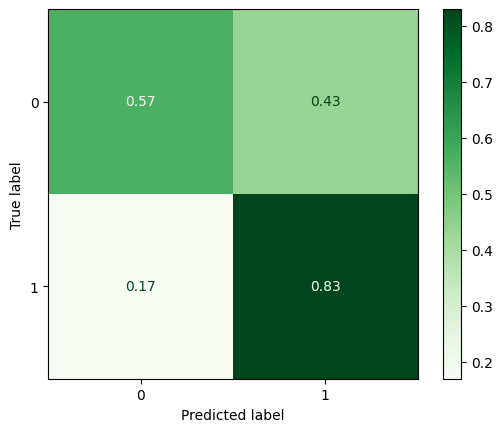

In [54]:
xgboost = eval_classification(boosted, X_train_proc, y_train, X_test_proc, y_test, model_name = 'xgboost', results_frame=rf_1)

In [55]:
xgboost

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.708701,0.740646,0.724349,0.694487,0.902672,0.716824,0.803738,0.796646,0.794191
dt_no_tune,1.000000,0.648172,1.000000,0.744511,1.000000,0.711832,1.000000,0.727805,1.000000,0.617998
rf_no_tune,1.000000,0.744010,1.000000,0.798883,1.000000,0.818702,1.000000,0.808671,1.000000,0.800796
RF 1 depth,0.665947,0.691047,0.654395,0.763705,0.689475,0.770992,0.671477,0.767331,0.745223,0.764810
xgboost,0.748921,0.740227,0.788668,0.788043,0.673349,0.830153,0.726461,0.808550,0.827486,0.801349


In [56]:
xg_gs = GridSearchCV(boosted,{"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200]},
        verbose=1,
        n_jobs=-1,
    )


In [57]:
xg_gs.fit(X_train_proc, y_train)
print(xg_gs.best_score_)
print(xg_gs.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.31387597941703327
{'max_depth': 2, 'n_estimators': 50}


In [58]:
xg_tune = xg_gs.best_estimator_

Train Evaluation
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      4679
           1       0.77      0.64      0.70      4589

    accuracy                           0.73      9268
   macro avg       0.73      0.73      0.72      9268
weighted avg       0.73      0.73      0.73      9268



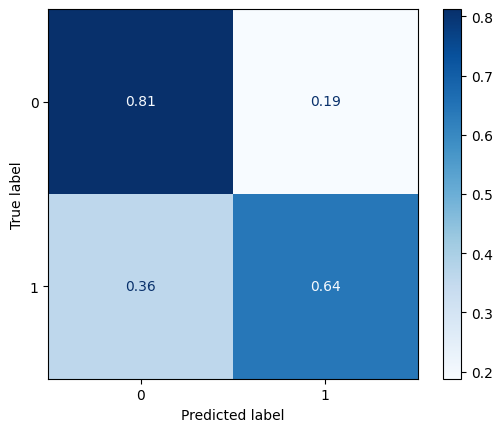

Test Evaluation
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       269
           1       0.80      0.81      0.81       524

    accuracy                           0.74       793
   macro avg       0.71      0.71      0.71       793
weighted avg       0.74      0.74      0.74       793



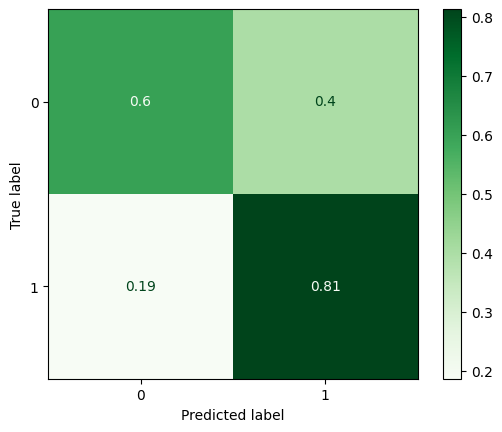

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.708701,0.740646,0.724349,0.694487,0.902672,0.716824,0.803738,0.796646,0.794191
dt_no_tune,1.000000,0.648172,1.000000,0.744511,1.000000,0.711832,1.000000,0.727805,1.000000,0.617998
rf_no_tune,1.000000,0.744010,1.000000,0.798883,1.000000,0.818702,1.000000,0.808671,1.000000,0.800796
RF 1 depth,0.665947,0.691047,0.654395,0.763705,0.689475,0.770992,0.671477,0.767331,0.745223,0.764810
xgboost,0.748921,0.740227,0.788668,0.788043,0.673349,0.830153,0.726461,0.808550,0.827486,0.801349
xg_tuned,0.727233,0.741488,0.769835,0.799250,0.640662,0.812977,0.699334,0.806055,0.798201,0.793095


In [59]:
boosted_tuned = eval_classification(xg_tune, X_train_proc, y_train, X_test_proc, y_test, model_name='xg_tuned', results_frame=xgboost)
boosted_tuned

In [60]:
explainer = shap.Explainer(boosted)
shap_values = explainer(X_test_proc)

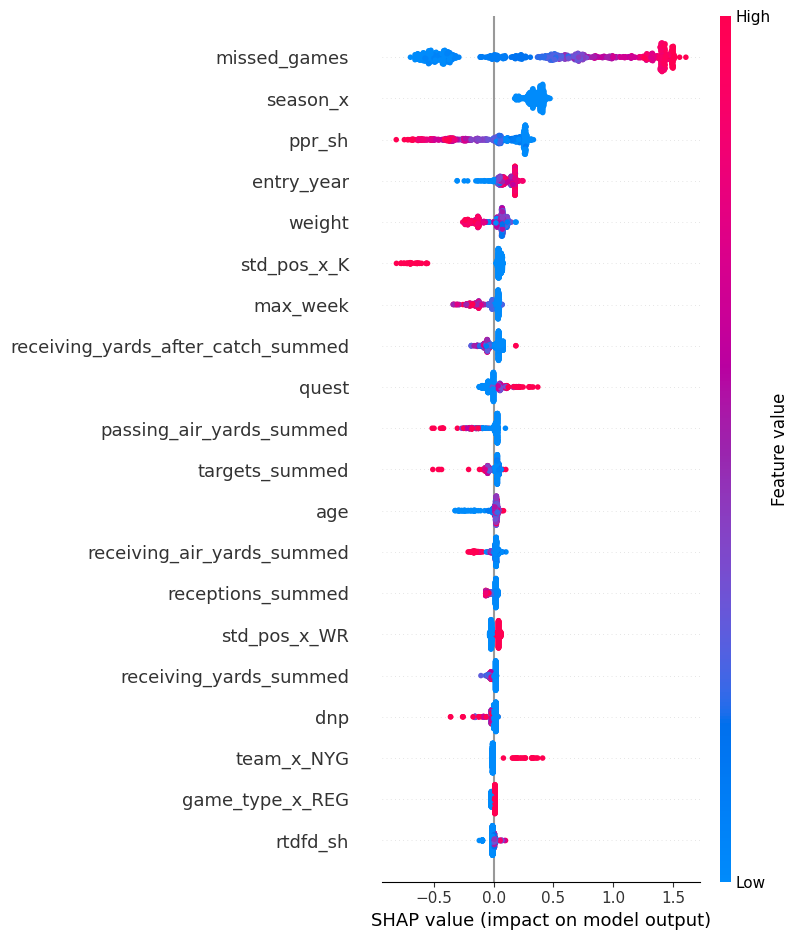

In [61]:
shap.summary_plot(shap_values, X_test_proc, feature_names = X_test_proc.columns) # for swarm plot

<function matplotlib.pyplot.show(close=None, block=None)>

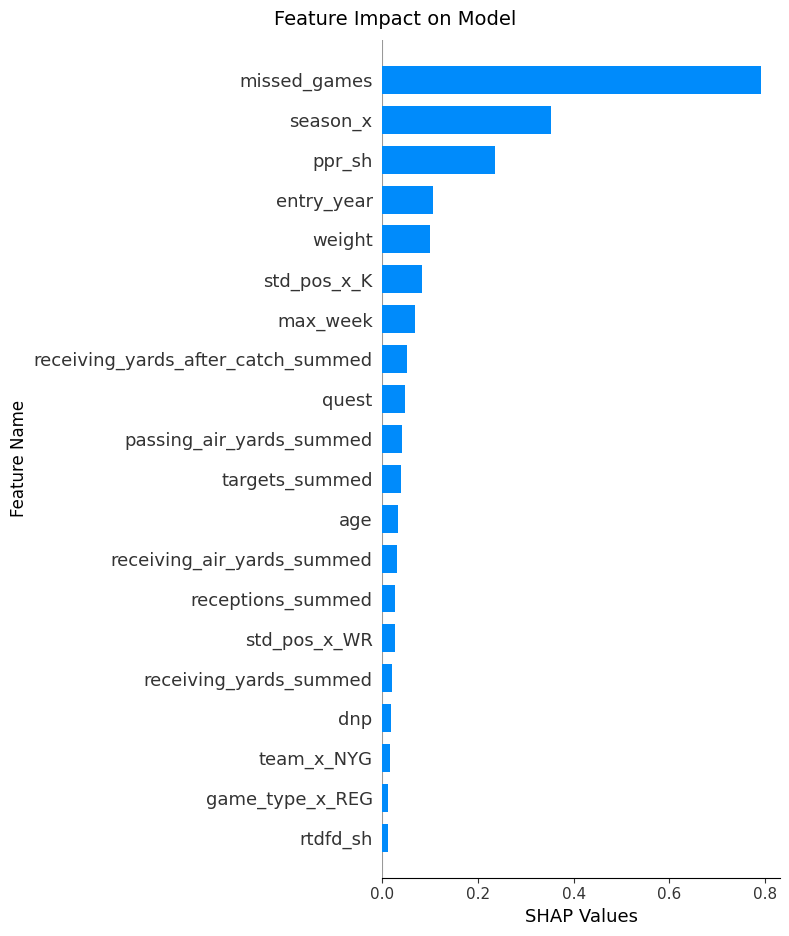

In [78]:
shap.summary_plot(shap_values, X_test_proc, feature_names = X_test_proc.columns, plot_type='bar', show=False) # for bar plot
plt.suptitle('Feature Impact on Model', fontsize = 14)
plt.xlabel('SHAP Values')
plt.ylabel("Feature Name", fontsize= 12)
plt.tight_layout()
plt.show

In [63]:
missed_games = df[['missed_games', 'next_season_missed']]

In [64]:
missed_games.dropna()

,missed_games,next_season_missed
13270,2.0,1.0
13268,14.0,5.0
13266,3.0,1.0
13264,9.0,4.0
13262,2.0,1.0
...,...,...
5,0.0,0.0
3,0.0,0.0
2,0.0,0.0
1,0.0,0.0


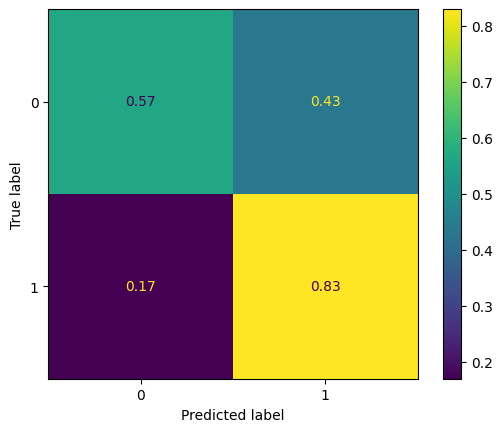

In [65]:
ConfusionMatrixDisplay.from_estimator(boosted, X_test_proc, y_test, normalize='true')

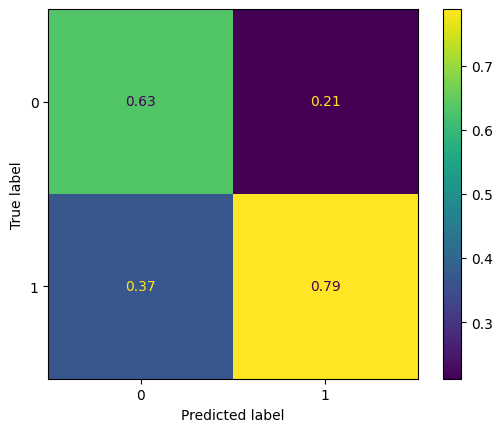

In [80]:
ConfusionMatrixDisplay.from_estimator(boosted, X_test_proc, y_test, normalize='pred')

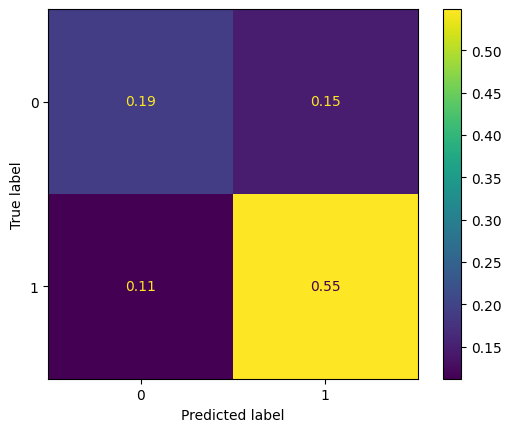

In [81]:
ConfusionMatrixDisplay.from_estimator(boosted, X_test_proc, y_test, normalize='all')

In [82]:

boosted2 = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    n_estimators=100,       # Number of trees
    learning_rate=0.1,      # Step size shrinkage
    random_state=42,
    objective='binary:logistic'
    device='cuda')

xg_gs2 = GridSearchCV(boosted2,{"max_depth": range(3,10,2), "n_estimators": [50, 100, 200], "min_child_weight": range(1,6,2)},
        verbose=1,
        n_jobs=-1,
        scoring='roc_auc',
        cv=5)


In [84]:
xg_gs2.fit(X_train_proc, y_train)
print(xg_gs2.best_score_)
print(xg_gs2.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.37163614312314824
{'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 50}


In [85]:
print(xg_gs2.best_score_)
print(xg_gs2.best_params_)
xg_tune2 = xg_gs2.best_estimator_

Train Evaluation
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      4679
           1       0.77      0.64      0.70      4589

    accuracy                           0.73      9268
   macro avg       0.73      0.73      0.72      9268
weighted avg       0.73      0.73      0.73      9268



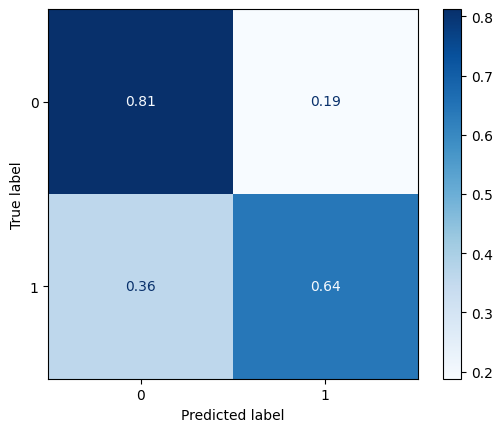

Test Evaluation
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       269
           1       0.80      0.81      0.81       524

    accuracy                           0.74       793
   macro avg       0.71      0.71      0.71       793
weighted avg       0.74      0.74      0.74       793



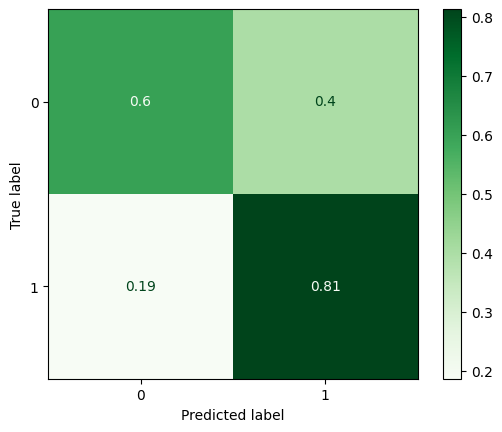

In [86]:
xg_fine_tune = eval_classification(xg_tune2, X_train_proc, y_train, X_test_proc, y_test, model_name='xg_fine_tune', results_frame=boosted_tuned)

In [87]:
xg_fine_tune


,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
log_reg_notune,0.728312,0.708701,0.740646,0.724349,0.694487,0.902672,0.716824,0.803738,0.796646,0.794191
dt_no_tune,1.000000,0.648172,1.000000,0.744511,1.000000,0.711832,1.000000,0.727805,1.000000,0.617998
rf_no_tune,1.000000,0.744010,1.000000,0.798883,1.000000,0.818702,1.000000,0.808671,1.000000,0.800796
RF 1 depth,0.665947,0.691047,0.654395,0.763705,0.689475,0.770992,0.671477,0.767331,0.745223,0.764810
xgboost,0.748921,0.740227,0.788668,0.788043,0.673349,0.830153,0.726461,0.808550,0.827486,0.801349
xg_tuned,0.727233,0.741488,0.769835,0.799250,0.640662,0.812977,0.699334,0.806055,0.798201,0.793095
xg_fine_tune,0.727233,0.741488,0.769835,0.799250,0.640662,0.812977,0.699334,0.806055,0.798128,0.793088


In [116]:

boosted_base = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=42,
    device='cuda')

boosted_base_gs = GridSearchCV(boosted_base,{"n_estimators": range(1, 1000, 1)},
        verbose=1,
        n_jobs=1,
        scoring='roc_auc',
        cv=5)


In [110]:
%pip install cupy-cuda12x

   ---------------------------------------- 0.0/82.2 MB ? eta -:--:--
   - -------------------------------------- 3.9/82.2 MB 21.3 MB/s eta 0:00:04
   ---- ----------------------------------- 9.4/82.2 MB 24.5 MB/s eta 0:00:03
   ------- -------------------------------- 14.7/82.2 MB 23.7 MB/s eta 0:00:03
   ---------- ----------------------------- 21.2/82.2 MB 24.8 MB/s eta 0:00:03
   ------------- -------------------------- 26.7/82.2 MB 24.9 MB/s eta 0:00:03
   ---------------- ----------------------- 33.0/82.2 MB 25.9 MB/s eta 0:00:02
   ------------------ --------------------- 38.5/82.2 MB 26.1 MB/s eta 0:00:02
   -------------------- ------------------- 41.7/82.2 MB 24.6 MB/s eta 0:00:02
   ----------------------- ---------------- 48.2/82.2 MB 25.4 MB/s eta 0:00:02
   --------------------------- ------------ 56.1/82.2 MB 26.5 MB/s eta 0:00:01
   ------------------------------ --------- 63.4/82.2 MB 27.1 MB/s eta 0:00:01
   -------------------------------- ------- 66.3/82.2 MB 27.5 M

In [111]:
try:
    import cupy as cp
    print(f"CuPy version: {cp.__version__}")
    print(f"CUDA version: {cp.cuda.runtime.runtimeGetVersion()}")
    print(f"CUDA available: {cp.cuda.is_available()}")
except ImportError:
    print("CuPy not installed")

c:\Users\nick_\anaconda3\envs\foozball\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


CuPy version: 13.4.1
CUDA version: 12080
CUDA available: True


In [115]:
X_train_gpu = cp.asarray(X_train_proc.values)
y_train_gpu = cp.asarray(y_train.values)
X_test_gpu = cp.asarray(X_test_proc.values)
y_test_gpu = cp.asarray(y_test.values)

In [118]:
X_train_proc.shape

(9268, 112)

In [123]:
9268*.2


1853.6000000000001

In [124]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

In [126]:
# Create DMatrix from your DataFrame

dtrain = xgb.DMatrix(X_train_proc, label=y_train)

In [143]:
params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}


result = xgb.cv(
  params,
  dtrain,
  num_boost_round=1000,
  early_stopping_rounds=150,
  nfold=5,
  seed=42,
  verbose_eval=True
)

[0]	train-auc:0.79514+0.00224	test-auc:0.76666+0.00935
[1]	train-auc:0.80606+0.00246	test-auc:0.77545+0.01014
[2]	train-auc:0.81494+0.00252	test-auc:0.77679+0.00937
[3]	train-auc:0.82029+0.00234	test-auc:0.77876+0.01107
[4]	train-auc:0.82574+0.00194	test-auc:0.77939+0.00943
[5]	train-auc:0.83011+0.00143	test-auc:0.78079+0.00797
[6]	train-auc:0.83412+0.00121	test-auc:0.78122+0.00807
[7]	train-auc:0.83831+0.00122	test-auc:0.78142+0.00895
[8]	train-auc:0.84127+0.00136	test-auc:0.78137+0.00891
[9]	train-auc:0.84452+0.00133	test-auc:0.78104+0.00939
[10]	train-auc:0.84746+0.00109	test-auc:0.78073+0.00976
[11]	train-auc:0.84939+0.00098	test-auc:0.78126+0.00957
[12]	train-auc:0.85236+0.00068	test-auc:0.78113+0.00957
[13]	train-auc:0.85453+0.00080	test-auc:0.78166+0.00879
[14]	train-auc:0.85745+0.00141	test-auc:0.78127+0.00912
[15]	train-auc:0.86040+0.00207	test-auc:0.78132+0.00918
[16]	train-auc:0.86265+0.00197	test-auc:0.78069+0.00871
[17]	train-auc:0.86460+0.00158	test-auc:0.78030+0.00884
[1

In [146]:
optimal_trees = result.shape[0]
optimal_trees

14

In [131]:

tune1 = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    max_depth=5,
    min_child_weight=1,
    n_estimators = optimal_trees,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=42,
    device='cuda')

tune1_gs = GridSearchCV(
  tune1,
  { 'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)},
  verbose=1,
  n_jobs=1,
  scoring='roc_auc',
  cv=5)


In [140]:
tune1.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': 'cuda',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 14,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 42}

In [132]:
tune1_gs.fit(X_train_proc, y_train)
print(tune1_gs.best_score_)
print(tune1_gs.best_params_)
tune1_tuned = tune1_gs.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.328778373359755
{'max_depth': 3, 'min_child_weight': 5}


In [149]:

tune2 = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    max_depth=5,
    min_child_weight=1,
    n_estimators = optimal_trees,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=42,
    device='cuda')

tune2_gs = GridSearchCV(
  tune2,
  { 'max_depth': [1,2,3,4], 'min_child_weight':[1,2,3,4,5,6]},
  verbose=1,
  n_jobs=1,
  scoring='roc_auc',
  cv=5)

tune2_gs.fit(X_train_proc, y_train)
print(tune2_gs.best_score_)
print(tune2_gs.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.7027747186636202
{'max_depth': 1, 'min_child_weight': 1}


In [151]:

tune3 = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    max_depth=1,
    min_child_weight=1,
    n_estimators = optimal_trees,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=42,
    device='cuda')

tune3_gs = GridSearchCV(
  tune3,
  {'gamma':[i/10.0 for i in range(0,5)]},
  verbose=1,
  n_jobs=-1,
  scoring='roc_auc',
  cv=5)

tune3_gs.fit(X_train_proc, y_train)
print(tune3_gs.best_score_)
print(tune3_gs.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.7027747186636202
{'gamma': 0.0}


In [152]:
params = {
    'max_depth': 1,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42
}


result = xgb.cv(
  params,
  dtrain,
  num_boost_round=1000,
  early_stopping_rounds=150,
  nfold=5,
  seed=42,
  verbose_eval=True
)

[0]	train-auc:0.70398+0.00242	test-auc:0.70275+0.00513
[1]	train-auc:0.71179+0.00295	test-auc:0.71202+0.00479
[2]	train-auc:0.74730+0.00294	test-auc:0.74704+0.00627
[3]	train-auc:0.75855+0.00616	test-auc:0.75654+0.00754
[4]	train-auc:0.76706+0.00412	test-auc:0.76418+0.00725
[5]	train-auc:0.77204+0.00326	test-auc:0.76934+0.00739
[6]	train-auc:0.77407+0.00188	test-auc:0.77061+0.00813
[7]	train-auc:0.77587+0.00235	test-auc:0.77273+0.00792
[8]	train-auc:0.77641+0.00195	test-auc:0.77392+0.00840
[9]	train-auc:0.77820+0.00194	test-auc:0.77593+0.00829
[10]	train-auc:0.77848+0.00209	test-auc:0.77632+0.00818
[11]	train-auc:0.77928+0.00237	test-auc:0.77717+0.00813
[12]	train-auc:0.77951+0.00182	test-auc:0.77725+0.00835
[13]	train-auc:0.78119+0.00190	test-auc:0.77879+0.00829
[14]	train-auc:0.78196+0.00243	test-auc:0.77879+0.00820
[15]	train-auc:0.78266+0.00254	test-auc:0.77880+0.00827
[16]	train-auc:0.78339+0.00241	test-auc:0.77985+0.00813
[17]	train-auc:0.78416+0.00239	test-auc:0.78045+0.00834
[1

In [153]:
optimal_trees = result.shape[0]
optimal_trees

110

In [157]:
tune4 = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    max_depth=1,
    min_child_weight=1,
    n_estimators = optimal_trees,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    seed=42,
    device='cpu')

tune4_gs = GridSearchCV(
  tune4,
  {'subsample':[i/100.0 for i in range(55, 70, 5)],
 'colsample_bytree':[i/100.0 for i in range(65, 80, 5)]},
  verbose=1,
  n_jobs=-1,
  scoring='roc_auc',
  cv=5)

tune4_gs.fit(X_train_proc, y_train)
print(tune4_gs.best_score_)
print(tune4_gs.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


0.3837186064727659
{'colsample_bytree': 0.65, 'subsample': 0.6}


In [162]:
tune5 = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    max_depth=1,
    min_child_weight=1,
    n_estimators = optimal_trees,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.65,
    objective= 'binary:logistic',
    seed=42,
    device='cpu')

tune5_gs = GridSearchCV(
  tune5,
  {'reg_alpha':[146,147,148,149,150,151,152,153,154]},
  verbose=1,
  n_jobs=-1,
  scoring='roc_auc',
  cv=5)

tune5_gs.fit(X_train_proc, y_train)
print(tune5_gs.best_score_)
print(tune5_gs.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.7687902358165044
{'reg_alpha': 147}


In [166]:
tune6 = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    max_depth=1,
    min_child_weight=1,
    n_estimators = optimal_trees,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.65,
    objective= 'binary:logistic',
    seed=42,
    reg_alpha=147,
    device='cpu')

tune6_gs = GridSearchCV(
  tune6,
  {'reg_lambda': [.2, .4, .6, .8, 1, 1.2, 1.4, 1.6]},
  verbose=1,
  n_jobs=-1,
  scoring='roc_auc',
  cv=5)

tune6_gs.fit(X_train_proc, y_train)
print(tune6_gs.best_score_)
print(tune6_gs.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.7687902358165044
{'reg_lambda': 1}


In [168]:

tune6_tuned = tune6_gs.best_estimator_

In [169]:
tune6_tuned

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.65, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Train Evaluation
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      4679
           1       0.72      0.67      0.69      4589

    accuracy                           0.71      9268
   macro avg       0.71      0.70      0.70      9268
weighted avg       0.71      0.71      0.70      9268



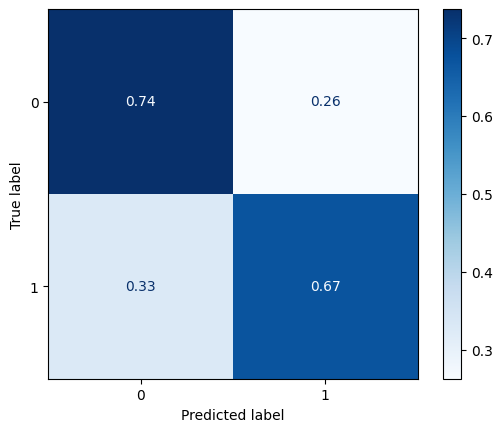

Test Evaluation
              precision    recall  f1-score   support

           0       0.62      0.46      0.53       269
           1       0.75      0.86      0.80       524

    accuracy                           0.72       793
   macro avg       0.69      0.66      0.66       793
weighted avg       0.71      0.72      0.71       793



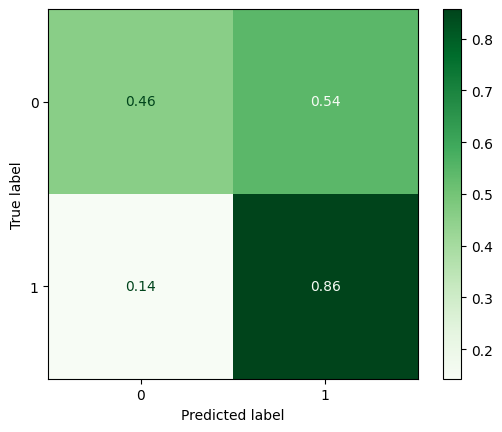

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
hypertuned,0.705006,0.721311,0.715048,0.754622,0.672042,0.85687,0.692878,0.802502,0.777814,0.788051


In [170]:
tuned1 = eval_classification(tune6_tuned, X_train_proc, y_train, X_test_proc, y_test, model_name='hypertuned')
tuned1

In [173]:
params = {
    'max_depth': 1,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.6,
    'colsample_bytree': 0.65,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'reg_alpha' : 147,
    'reg_lambda' : 1,
    'seed': 42,
    'learning_rate' : 0.03
}


result = xgb.cv(
  params,
  dtrain,
  num_boost_round=5000,
  early_stopping_rounds=150,
  nfold=5,
  seed=42,
  verbose_eval=True
)

[0]	train-auc:0.70460+0.00224	test-auc:0.70239+0.00493
[1]	train-auc:0.70921+0.00281	test-auc:0.70799+0.00906
[2]	train-auc:0.72921+0.00158	test-auc:0.72948+0.00616
[3]	train-auc:0.72921+0.00158	test-auc:0.72948+0.00616
[4]	train-auc:0.75731+0.00313	test-auc:0.75656+0.00735
[5]	train-auc:0.76027+0.00210	test-auc:0.75836+0.00952
[6]	train-auc:0.76110+0.00244	test-auc:0.75962+0.00840
[7]	train-auc:0.76086+0.00261	test-auc:0.75923+0.00858
[8]	train-auc:0.76104+0.00257	test-auc:0.75954+0.00809
[9]	train-auc:0.76640+0.00313	test-auc:0.76417+0.00839
[10]	train-auc:0.76641+0.00314	test-auc:0.76425+0.00846
[11]	train-auc:0.76633+0.00324	test-auc:0.76403+0.00850
[12]	train-auc:0.76824+0.00183	test-auc:0.76605+0.00998
[13]	train-auc:0.76831+0.00198	test-auc:0.76623+0.00995
[14]	train-auc:0.76823+0.00182	test-auc:0.76612+0.00999
[15]	train-auc:0.76773+0.00170	test-auc:0.76544+0.00963
[16]	train-auc:0.76773+0.00170	test-auc:0.76544+0.00963
[17]	train-auc:0.76883+0.00193	test-auc:0.76650+0.00802
[1

In [174]:
optimal_trees = result.shape[0]
optimal_trees

1049

In [176]:
tune7 = xgb.XGBClassifier(  # Use XGBRegressor for regression tasks
    max_depth=1,
    min_child_weight=1,
    n_estimators = optimal_trees,
    gamma=0,
    subsample=0.6,
    colsample_bytree=0.65,
    objective= 'binary:logistic',
    seed=42,
    reg_alpha=147,
    reg_lambda=1,
    device='cpu')


Train Evaluation
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      4679
           1       0.72      0.68      0.70      4589

    accuracy                           0.71      9268
   macro avg       0.71      0.71      0.71      9268
weighted avg       0.71      0.71      0.71      9268



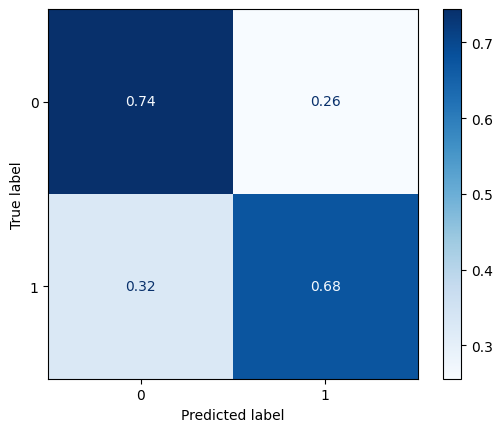

Test Evaluation
              precision    recall  f1-score   support

           0       0.62      0.44      0.52       269
           1       0.75      0.86      0.80       524

    accuracy                           0.72       793
   macro avg       0.69      0.65      0.66       793
weighted avg       0.71      0.72      0.71       793



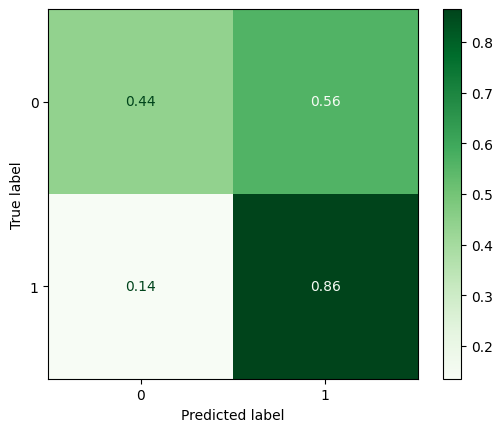

In [177]:
tuned2 = eval_classification(tune7, X_train_proc, y_train, X_test_proc, y_test, model_name='hypertuned2', results_frame=tuned1)

In [178]:
tuned2

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
hypertuned,0.705006,0.721311,0.715048,0.754622,0.672042,0.856870,0.692878,0.802502,0.777814,0.788051
hypertuned2,0.709970,0.720050,0.721201,0.750000,0.675311,0.864504,0.697502,0.803191,0.778960,0.786781


In [167]:
tune6.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.65, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)>

In [121]:
X_test.shape

(793, 66)

In [117]:

boosted_base_gs.fit(X_train_proc, y_train)
print(boosted_base_gs.best_score_)
print(boosted_base_gs.best_params_)
bb_tuned = boosted_base_gs.best_estimator_

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

Train Evaluation
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4679
           1       0.89      0.86      0.88      4589

    accuracy                           0.88      9268
   macro avg       0.88      0.88      0.88      9268
weighted avg       0.88      0.88      0.88      9268



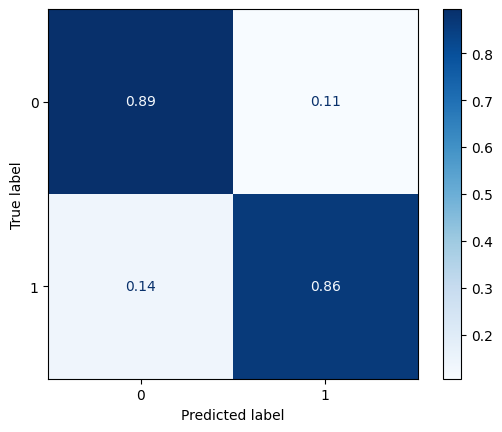

Test Evaluation
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       269
           1       0.79      0.82      0.81       524

    accuracy                           0.74       793
   macro avg       0.71      0.70      0.70       793
weighted avg       0.73      0.74      0.74       793



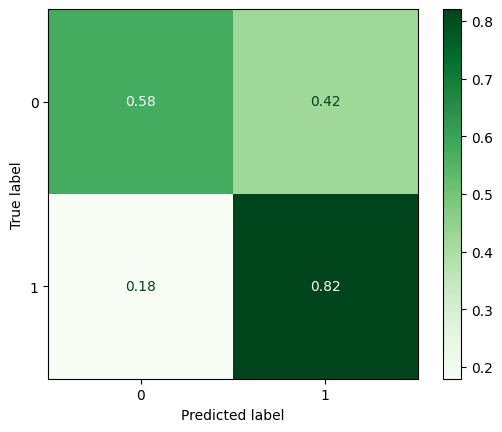

In [98]:
boosted_base = eval_classification(boosted_base, X_train_proc, y_train, X_test_proc, y_test, model_name='boosted base')

In [99]:
boosted_base

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
boosted base,0.878291,0.737705,0.888789,0.790441,0.862061,0.820611,0.875221,0.805243,0.947627,0.795653


In [ ]:

xg_gs_base = GridSearchCV(boosted_base,{"max_depth": range(3,10,2), "n_estimators": [50, 100, 200], "min_child_weight": range(1,6,2)},
        verbose=1,
        n_jobs=-1,
        scoring='roc_auc',
        cv=5)